In [1]:
from decimal import Decimal, getcontext
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit
import pandas as pd
import os
from tqdm.notebook import tqdm

from IPython.utils import io
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [2]:
def find_primes(number_of_sets,lenght_of_sets):
    """
    Generates a dictionary containing for each one of its entries a list of prime numbers as intergers
    
    number_of_sets == number of entries to be placed on the output dictionary as an int value
    lenght_of_sets == lenght of each list corresponding to each dicitionay entrie as an int value
    """
    #strts test at number 4
    number_tested = 3
    sets_disc = {}
    #store sets of primes for the output
    sets_disc[0] = [2,3]
    #store all primes to check for future primes
    all_primes = [2,3]
    #restrains for the number of sets desired
    for i in range (number_of_sets):
        #check to create an empty list if not first dictionary key
        if i >= 1:
                sets_disc[i] = []
        #restrains for the number of elements in each desired set
        while len(sets_disc[i]) < lenght_of_sets:
            #actual cicle to find prime numbers
            number_tested += 1
            checker = 0
            for k in all_primes:
                if number_tested % k != 0:
                    pass
                else:
                    checker = 1
                    break
            if checker == 0:
                all_primes.append(number_tested)
                sets_disc[i].append(number_tested)
        
    return(sets_disc)
             
#use prime numbers to generate time-series wuth desired length
def get_inputs(length, prime_list):
    """
    Calculation of a square root of prime numbers, generating irrational values, to create time-series
    by using the individual decimal characters of the result
    
    length = length of the deseired final time-series as an int value
    prime_list = list of prime numbers (as ints) to be used on time-series generation
    
    """
    n_of_inputs = len(prime_list)
    #generates 2D array for individual sqr of prime numbers
    array_of_inputs = np.zeros((n_of_inputs,length))
    #required to generate sqrt with desired decimal numbers
    getcontext().prec = length + 9
    
    for n in range(n_of_inputs):
        sqrt = Decimal(prime_list[n]).sqrt()
        #takes values after the 10 first to avoid including the decimal separator
        sqrt_str = str(sqrt)[10:]
        lista = [int(i) for i in sqrt_str]
        array_of_inputs[n] = np.array(lista)
    
    #generate a singular array to be the main object of operations as a time-series
    singular_array = array_of_inputs[0]
    #sums and subtractions to allow for semi random values that are still dependent from the original sqrt values
    for n in range(1,len(array_of_inputs[:,0])):
        if n % 2 != 0:
            singular_array = singular_array - array_of_inputs[n]
        else:
            singular_array = singular_array + array_of_inputs[n]
    
    return array_of_inputs, singular_array



#gets cossine both for single array or 2D array
def get_cossine(scaling_factor,n_of_periods,start_point_oscilation,noise_level,array_of_inputs):
    """
    Generates a cossine wave with a noise generated by a list, with customizable scale, number of periods and oscilation of the starting point 
    
    scaling_factor = float type to indicate the amplitude of the wave
    n_of_periods = desired number of periods for every 365 datapoints as an integer
    start_point_oscilation = oscilation on the inintial wave value as a float value below 1
    array_of_inputs = array either 1D or 2D to be used as noise for the time-series as float
    noise_level = intendity on wich the array_of_inputs used as noise will affect the wave
    
    """
    #check if the array_of_inputs has 2 dimensions
    try:
        array_of_inputs.shape[1]
        array_type = "array_of_inputs"
    except:
        array_type = "singular_array"
        
    if array_type == "array_of_inputs":
        length = len(array_of_inputs[0])
        oscilation = int(start_point_oscilation*length)
        array_of_cossines = np.zeros((array_of_inputs.shape[0],length))
        #frequency atenuation to obtain desired periods
        f_attenuation = length/(n_of_periods*length//365)/6.29
        
        for n in (range(array_of_inputs.shape[0])):
            #generates a normalization of the generated noise for the wave
            input_norm_Cos = [i*noise_level/np.pi for i in array_of_inputs[n]]
            cossine = scaling_factor*np.cos(np.arange(sum(array_of_inputs[n,:oscilation]),length+sum(array_of_inputs[n,:oscilation]))/f_attenuation-input_norm_Cos)
            array_of_cossines[n,:] = cossine
    
    #same process but for a 1D array
    if array_type == "singular_array":
        length = len(array_of_inputs)
        oscilation = int(start_point_oscilation*length)
        array_of_cossines = np.zeros((length))
        f_attenuation = length/(n_of_periods*length//365)/6.29
        input_norm_Cos = [i*noise_level/np.pi for i in array_of_inputs]
        cossine = scaling_factor*np.cos(np.arange(sum(array_of_inputs[:oscilation]),length+sum(array_of_inputs[:oscilation]))/f_attenuation-input_norm_Cos)
        array_of_cossines = cossine
                
    return array_of_cossines 



#gets sine both for single array or 2D array
def get_sine(scaling_factor,n_of_periods,start_point_oscilation,noise_level,array_of_inputs):
    """
    Generates a sine wave with a noise generated by a list, with customizable scale, number of periods and oscilation of the starting point 
    
    scaling_factor = float type to indicate the amplitude of the wave
    n_of_periods = desired number of periods for every 365 datapoints as an integer
    start_point_oscilation = oscilation on the inintial wave value as a float value below 1
    array_of_inputs = array either 1D or 2D to be used as noise for the time-series as float
    noise_level = intendity on wich the array_of_inputs used as noise will affect the wave
    
    """
    #check if the array_of_inputs has 2 dimensions
    try:
        array_of_inputs.shape[1]
        array_type = "array_of_inputs"
    except:
        array_type = "singular_array"
        
    if array_type == "array_of_inputs":
        length = len(array_of_inputs[0])
        oscilation = int(start_point_oscilation*length)
        array_of_sines = np.zeros((array_of_inputs.shape[0],length))
        #frequency atenuation to obtain desired periods
        f_attenuation = length/(n_of_periods*length//365)/6.29
        
        for n in (range(array_of_inputs.shape[0])):
            #generates a normalization of the generated noise for the wave
            input_norm_Sin = [i*noise_level/np.pi for i in array_of_inputs[n]]
            sine = scaling_factor*np.sin(np.arange(sum(array_of_inputs[n,:oscilation]),length+sum(array_of_inputs[n,:oscilation]))/f_attenuation-input_norm_Sin)
            array_of_sines[n,:] = sine
    
    #same process but for a 1D array
    if array_type == "singular_array":
        length = len(array_of_inputs)
        oscilation = int(start_point_oscilation*length)
        array_of_sines = np.zeros((length))
        f_attenuation = length/(n_of_periods*length//365)/6.29
        input_norm_Sin = [i*noise_level/np.pi for i in array_of_inputs]
        sine = scaling_factor*np.sin(np.arange(sum(array_of_inputs[:oscilation]),length+sum(array_of_inputs[:oscilation]))/f_attenuation-input_norm_Sin)
        array_of_sines = sine
                
    return array_of_sines 


def get_ln(list_of_inputs, max_value):
    """
    Return the ln of the list resulting of the partial sums of another list
    
    list_of_inputs = values to be used on summation and ln value generation as float or int
    max_value = upper bound for the otput list value as float or int
    """
    list_of_sums=[]
    length = len(list_of_inputs)
    sums_n= 0
    for n in range(length):
        sums_n += abs(list_of_inputs[n])            
        list_of_sums.append(np.log((sums_n)))
    list_of_sums  = [max_value*i/(np.max(list_of_sums)) for i in list_of_sums]
    return list_of_sums

def linear_trend(list_of_inputs, max_value):
    """
    Return the list resulting of the partial sums of another list
    
    list_of_inputs = values to be used on summation and ln value generation as float or int
    max_value = upper bound for the otput list value as float or int
    """
    list_of_sums=[]
    length = len(list_of_inputs)
    sums_n= 0
    for n in range(len(list_of_inputs)):
        sums_n += list_of_inputs[n]
        list_of_sums.append(sums_n)
    list_of_sums = [max_value*i/(np.max(list_of_sums)-np.min(list_of_sums)) for i in list_of_sums]
    return list_of_sums


def get_promo_effects(data,normal_behaviour):
    """
    Generates campaign effects on a time series by using statistical analysis over another time-series,
    returns positinos of promotional effects and altered time-series
    
    data = time-series used for statistical analysis
    normal_behaviour = time-series to have campaign effects
    """
    singular_list = data
    
    index_under= {}
    index_above={}

    # Create a histogram
    hist, bin_edges = np.histogram(data, bins=80, density=True)

    # Calculate the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Define the normal distribution function
    def normal_distribution(x, mu, sigma):
        return norm.pdf(x, mu, sigma)

    # Fit the normal distribution parameters to the data
    params, covariance = curve_fit(normal_distribution, bin_centers, hist, p0=[0, 1])

    # Extract the mean and standard deviation from the fitted parameters
    mu, sigma = params
    normal_dist = norm(loc=mu, scale=sigma)

    #quantiles representing "bad sales" or "promotions"
    bad_sales = [0.075, 0.05, 0.025]

    promotions = [0.925, 0.95, 0.975]

    for i in range(3):
        bad = bad_sales[i]
        promo = promotions[i]
        #gets index of values on time series above or under a set quantile threshold
        quantile_promo = normal_dist.ppf(promo)
        quantile_bad = normal_dist.ppf(bad)
        indices_under_threshold = [index for index, value in enumerate(singular_list) if value < quantile_bad]
        indices_above_threshold = [index for index, value in enumerate(singular_list) if value > quantile_promo]

        index_under[i]= indices_under_threshold
        index_above[i]= indices_above_threshold
        #generates a smoothing profile for the cmapaign effect, both for increase and decrease
        smoothing_bad1 = np.linspace(0.8,0.3,4)
        smoothing_bad2 = np.linspace(0.4,0.8,3)

        smoothing_promo1 = np.linspace(1.1,1.4,4)
        smoothing_promo2 = np.linspace(1.3,1.1,3)

        smoothing_bad = np.append(smoothing_bad1,smoothing_bad2)
        smoothing_promo = np.append(smoothing_promo1,smoothing_promo2)
        #apply the campaign effects on the time-series
        for j in (indices_under_threshold):
            for k in range(len(smoothing_promo)):
                try:
                    normal_behaviour[j+(k-2)] = normal_behaviour[j+(k-2)]*smoothing_bad[k]
                    normal_behaviour[j+(k-2)] = normal_behaviour[j+(k-2)]*smoothing_promo[k]
                except:
                    pass
    #get index of camapaigns individualy by strenght of campaign effect
    index_under[0] = [value for value in index_under[0] if value not in index_under[1]]
    index_under[1] = [value for value in index_under[1] if value not in index_under[2]]
    
    index_above[0] = [value for value in index_above[0] if value not in index_above[1]]
    index_above[1] = [value for value in index_above[1] if value not in index_above[2]]

    return index_under,index_above,normal_behaviour

In [3]:
def get_time_series(numer_of_time_series, lenght_of_time_series):
    """
    Aggregates all functions created to allow for the generation of a synthetic time-series
    
    numer_of_time_series = number of time-series desired, as an integer
    lenght_of_time_series = length of each time-series as an integer
    """
    #find_primes(number_of_sets,lenght_of_sets)
    #breaks for quantities of prime numbers above 60, unknown reason for now
    prime_dic_list=find_primes(numer_of_time_series,10)
    exogenous_features = {}

    for prime_list_number in prime_dic_list.keys(): 
        #get_inputs(length, prime_list)
        inputs,singular_list = get_inputs(lenght_of_time_series,prime_dic_list[prime_list_number])
        
        #get_cossine(scaling_factor,n_of_periods,start_point_oscilation,array_of_inputs,noise_level)
        cossine = get_cossine(0.6,4,0.1,0.15,singular_list)
        #get_sine(scaling_factor,n_of_periods,start_point_oscilation,array_of_inputs,noise_level)
        sine = get_sine(2,52,0.1,0.4,singular_list)
        #get_ln(list_of_inputs, max_value):
        logs = np.array(get_ln(singular_list,1))
        #linear_trend(list_of_inputs, max_value):
        linear = np.array(linear_trend(singular_list,10))
        
        exog_coss = get_cossine(1,4,0.1,1,inputs)
        exog_sine = get_sine(0.6,52,0.1,0.4,inputs)
        
        trend = np.array(linear)+(0.8/np.array(logs))
        normal_behaviour = abs(trend+sine+cossine)
        
        #get_promo_effects(data,normal_behaviour):
        index_under,index_above,normal_behaviour = get_promo_effects(singular_list,normal_behaviour)
        
        
        #using data to generated a csv file of a time-series with exogenous features
        
        exogenous_features['TGT'] = normal_behaviour
        exogenous_features['singular_array'] = singular_list
        for number_of_array in range(inputs.shape[0]):
            exogenous_features[f'prime_sqr_n_{number_of_array}'] = inputs[number_of_array]
            exogenous_features[f'sine_prime_sqr_n_{number_of_array}'] = exog_sine[number_of_array]
            exogenous_features[f'coss_prime_sqr_n_{number_of_array}'] = exog_coss[number_of_array]
            
            
        for strength in range(3):
            exogenous_features[f'promotional_effect_strength_{strength}'] = np.zeros(lenght_of_time_series)    
            exogenous_features[f'LowSakes_effect_strength_{strength}'] = np.zeros(lenght_of_time_series)  
        
            for position in index_under[strength]:
                for i in range (3):
                    try:
                        exogenous_features[f'promotional_effect_strength_{strength}'][position-i] = 1
                        exogenous_features[f'LowSales_effect_strength_{strength}'][position-i] = 1
                    except:
                        pass
                
        df = pd.DataFrame(exogenous_features)
        os.makedirs('Synthetic_Datasets', exist_ok=True)
        df.to_csv(f'Synthetic_Datasets/Data_number_{prime_list_number}.csv', index=False)
        
    
    #shows the last time-series graph and dataframe for confirmation
    plt.figure(figsize = (50,20))
    plt.plot(np.arange(lenght_of_time_series),normal_behaviour, label = 'Time-series')
    plt.plot(np.arange(lenght_of_time_series),linear, label = 'Linear portion of trend')
    plt.plot(np.arange(lenght_of_time_series),logs, label = 'Logaritmic portion of trend')
    plt.plot(np.arange(lenght_of_time_series),trend, label = 'Trend')
    plt.legend()
    plt.show()
    
    return (df)
        

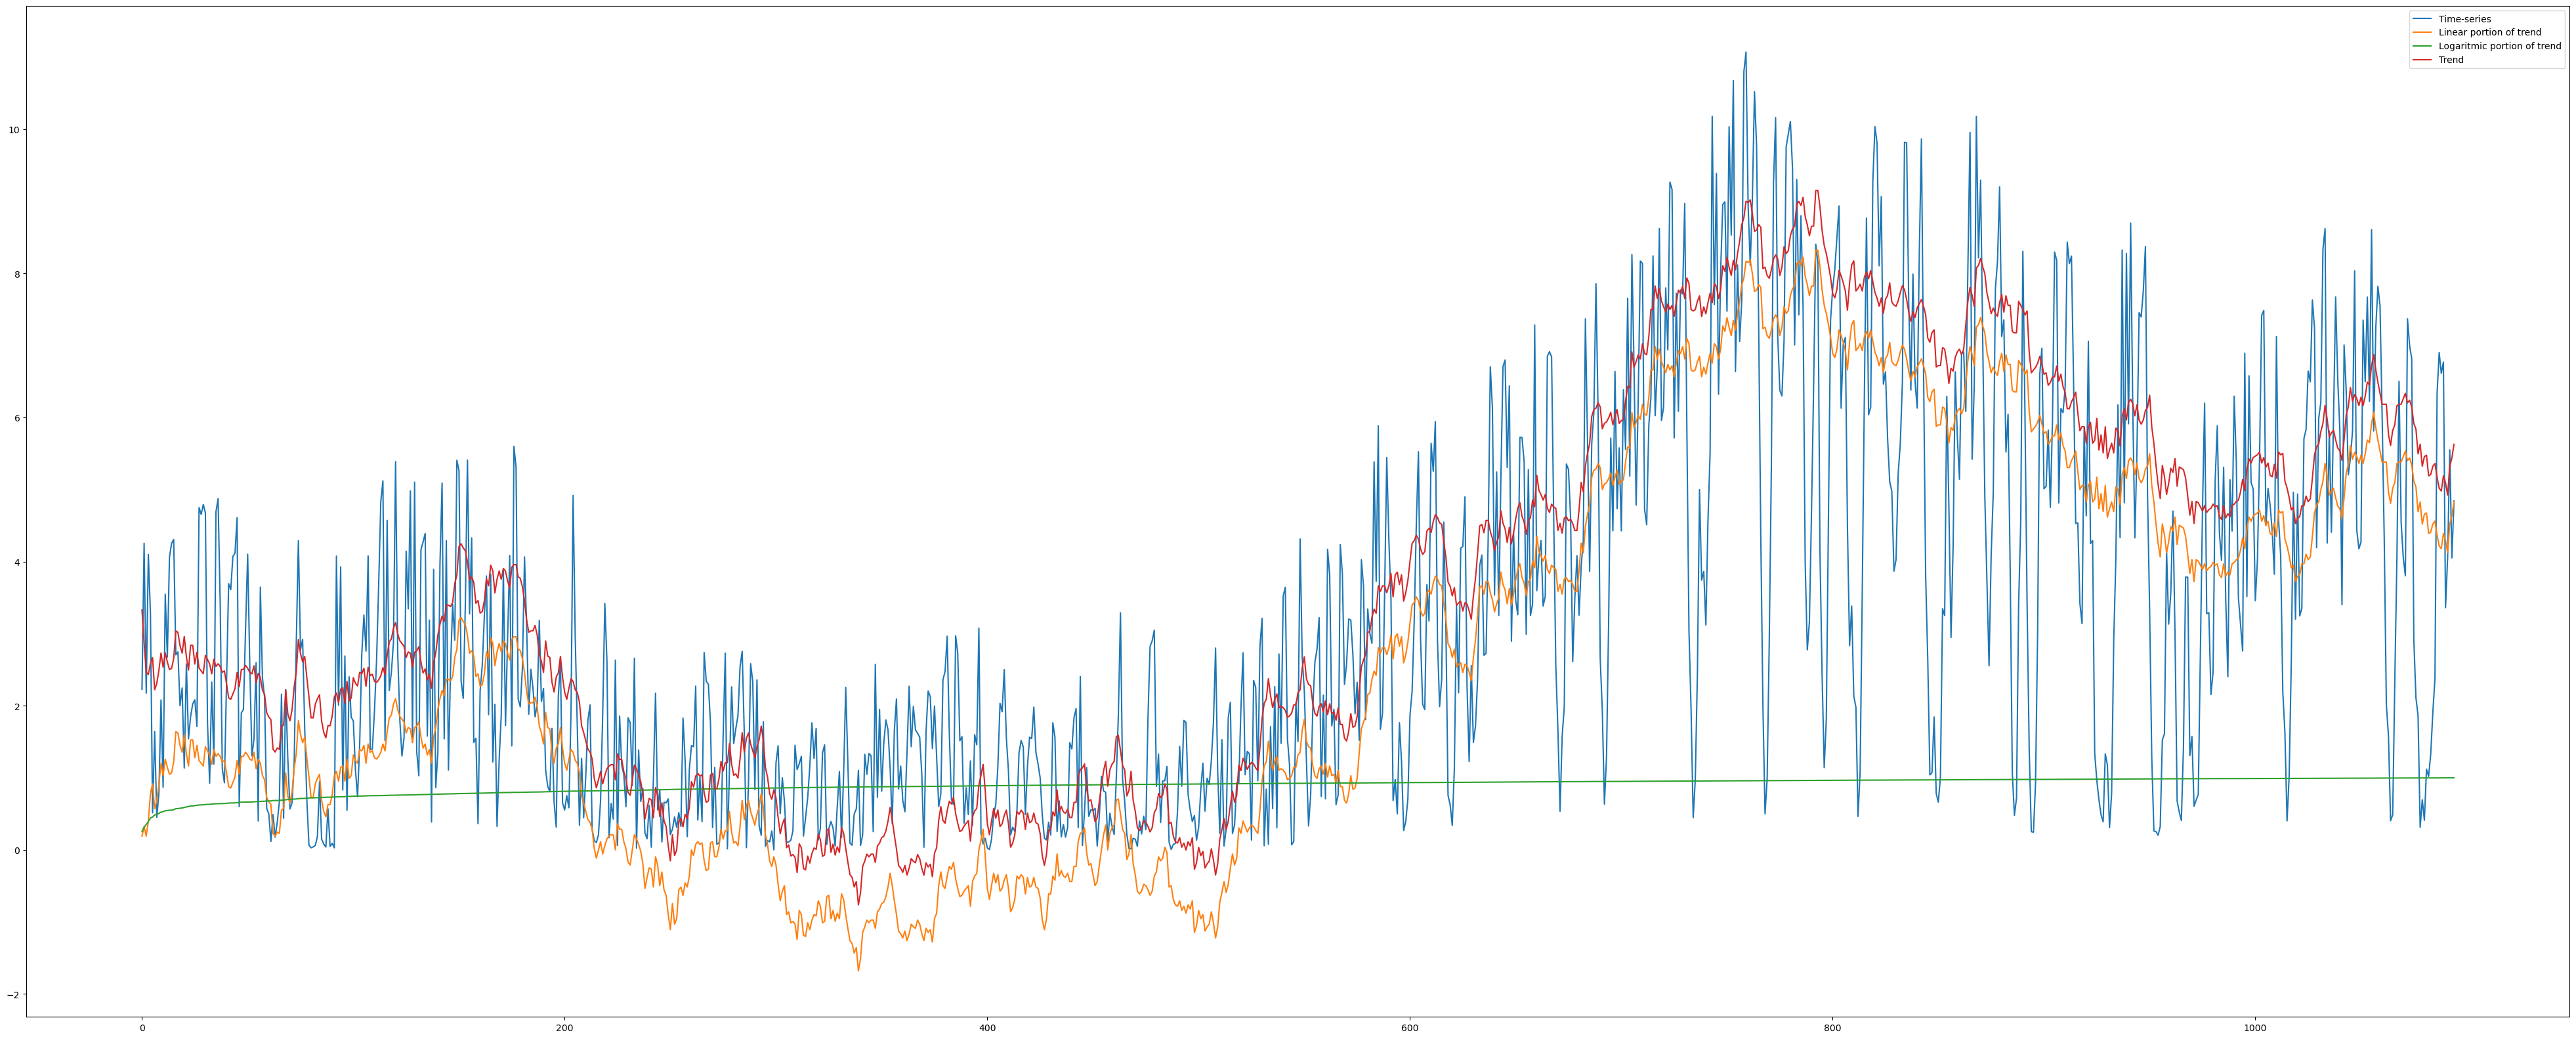

,TGT,singular_array,prime_sqr_n_0,sine_prime_sqr_n_0,coss_prime_sqr_n_0,prime_sqr_n_1,sine_prime_sqr_n_1,coss_prime_sqr_n_1,prime_sqr_n_2,sine_prime_sqr_n_2,...,coss_prime_sqr_n_8,prime_sqr_n_9,sine_prime_sqr_n_9,coss_prime_sqr_n_9,promotional_effect_strength_0,LowSakes_effect_strength_0,promotional_effect_strength_1,LowSakes_effect_strength_1,promotional_effect_strength_2,LowSakes_effect_strength_2
0,2.228653,10.0,2.0,0.446607,0.915441,9.0,-0.494477,0.607516,9.0,-0.570513,...,0.949955,3.0,-0.560767,-0.453062,0.0,0.0,0.0,0.0,0.0,0.0
1,4.255301,7.0,9.0,0.448542,-0.173368,5.0,0.253795,0.911325,9.0,-0.501450,...,0.760862,5.0,-0.576992,-0.861332,0.0,0.0,0.0,0.0,0.0,0.0
2,2.174435,-7.0,0.0,0.151447,0.372889,5.0,0.583095,0.880805,4.0,0.310143,...,0.684804,6.0,-0.300302,-0.960073,0.0,0.0,0.0,0.0,0.0,0.0
3,4.098235,11.0,5.0,-0.002590,0.944758,8.0,0.577260,0.923856,9.0,0.431550,...,0.733370,0.0,0.544142,0.637714,0.0,0.0,0.0,0.0,0.0,0.0
4,3.277854,20.0,1.0,-0.592233,0.533359,1.0,-0.283844,-0.327392,8.0,0.580544,...,-0.371888,3.0,0.598118,-0.193247,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,3.360835,-5.0,7.0,0.043719,0.130188,1.0,0.134409,0.203630,2.0,0.573096,...,0.965802,3.0,0.481439,-0.669160,0.0,0.0,0.0,0.0,0.0,0.0
1091,4.063923,-9.0,7.0,-0.439987,0.198170,3.0,-0.242205,0.698109,1.0,0.146563,...,0.903352,1.0,0.523276,-0.027523,0.0,0.0,0.0,0.0,0.0,0.0
1092,5.551308,21.0,8.0,-0.599866,-0.049867,4.0,-0.555745,0.853222,3.0,-0.230715,...,-0.144658,2.0,0.172001,-0.273380,0.0,0.0,0.0,0.0,0.0,0.0
1093,4.051252,6.0,1.0,0.141310,0.779821,9.0,-0.595168,0.562034,8.0,-0.365107,...,0.531512,0.0,-0.454710,0.415640,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
get_time_series(100,1095)